# **Proyecto de Práctica: Predicción de supervivientes de Titanic**

## Introducción
Ahora que ya tienes una idea de cómo optimizar tu flujo de trabajo de aprendizaje automático, vamos a practicar con un conjunto de datos del mundo real.
Utilizarás validación cruzada y una búsqueda en cuadrícula de hiperparámetros para optimizar tu flujo de trabajo.

Trabajarás con el Conjunto de Datos de Supervivencia del Titanic para construir un modelo de clasificación que prediga si un pasajero sobrevivió al hundimiento del Titanic, basándose en los atributos de cada pasajero en el conjunto de datos.

Comenzarás construyendo un Clasificador de Bosque Aleatorio (Random Forest), luego modificarás tu flujo de trabajo para usar un estimador de Regresión Logística en su lugar. Evaluarás y compararás tus resultados.

Este laboratorio te ayudará a prepararte para completar el Proyecto Final.

## Objetivos
Al completar este laboratorio serás capaz de:

Utilizar scikit-learn para construir un modelo que resuelva un problema de clasificación.

Implementar un flujo de trabajo (pipeline) para combinar tus pasos de preprocesamiento con un modelo de aprendizaje automático.

Interpretar los resultados de tu modelado.

Actualizar tu flujo de trabajo con un modelo de aprendizaje automático diferente.

Comparar el rendimiento de tus clasificadores.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Conjunto de datos de pasajeros del Titanic
Trabajaremos con el conjunto de datos de pasajeros del Titanic para construir un modelo de clasificación que prediga si un pasajero sobrevivió al hundimiento del Titanic.
A continuación se muestra el diccionario de datos:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |

### Carga los datos del titanic usando Seaborns

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Seleciona caracteristicas y objetivos

In [3]:
titanic.count()

survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64

Variables a eliminar
deck tiene muchos valores faltantes, así que la eliminaremos. age también tiene bastantes valores faltantes. Aunque podría ser relevante, embarked y embark_town no parecen especialmente importantes, así que también las eliminaremos. No está claro a qué se refiere alive, así que la ignoraremos.

Variable objetivo
survived es nuestra variable objetivo de clase.

In [4]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

### Ejercicio 1. Que tan balanceadas son las clases?

In [5]:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

Así que aproximadamente el 38% de los pasajeros en el conjunto de datos sobrevivió.

Debido a este ligero desequilibrio, deberíamos estratificar los datos al realizar la división entrenamiento/prueba y durante la validación cruzada.

### Ejercicio 2: Dividir los datos en conjuntos de entrenamiento y prueba
No olvides considerar el desequilibrio en la variable objetivo.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Definir transformadores de preprocesamiento para características numéricas y categóricas
#### Detectar automáticamente las columnas numéricas y categóricas, y asignarlas a características separadas

In [7]:
numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

#### Definir flujos de preprocesamiento separados para ambos tipos de características

In [8]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Combinar los transformadores en un único transformador de columnas
Utilizaremos el estimador ColumnTransformer de sklearn para transformar las características por separado, luego concatenará la salida como un único espacio de características, listo para ser utilizado por un estimador de aprendizaje automático.

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Crear un pipeline de modelo
Ahora completemos el pipeline del modelo combinando el preprocesamiento con un clasificador Random Forest.

In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### Definir una cuadrícula de parámetros
Utilizaremos esta cuadrícula en una búsqueda con validación cruzada para optimizar el modelo.

In [11]:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

### Realizar búsqueda en cuadrícula con validación cruzada y ajustar el mejor modelo a los datos de entrenamiento

In [12]:
# Cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

### Ejercicio 3. Entrenar el modelo del pipeline

In [13]:
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['pclass',
                                                                          'age',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['sex',
                                                                          'class',
                                                                          'who'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

### Ejercicio 4. Obtener las predicciones del modelo del estimador de búsqueda en cuadrícula en los datos no vistos
También imprimir un reporte de clasificación

In [14]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



### Ejercicio 5. Graficar la matriz de confusión

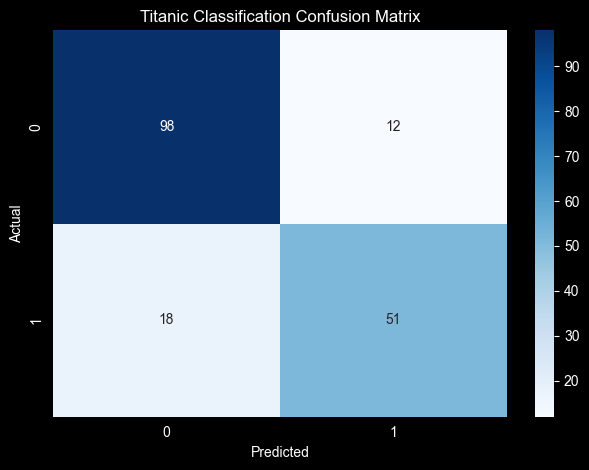

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

## Caracteristicas Importantes
Vamos a descubrir cómo obtener la importancia de las características de nuestro modelo. Necesitarás saber cómo hacer esto para tu proyecto final.

Primero, para obtener la importancia de las características categóricas, debemos retroceder a través del pipeline del modelo para asociar las importancias de las características con sus características categóricas originales que fueron transformadas mediante one-hot encoding.

No necesitamos rastrear las características numéricas de la misma manera, porque no las transformamos en nuevas características. Recordemos que convertimos las características categóricas en características codificadas mediante one-hot usando el transformador de columnas 'cat'.

Así es cómo rastreamos a través del modelo entrenado para acceder a los nombres de las características codificadas con one-hot

In [16]:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman'], dtype=object)

Observa cómo se nombran las características codificadas con one-hot. Por ejemplo, la variable sex se dividió en dos características booleanas que indican si el sexo es masculino o femeniano.

¡Excelente! Ahora vamos a obtener todas las importancias de características y asociarlas con sus nombres de características transformados.

In [17]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

# Combine the numerical and one-hot encoded categorical feature names
feature_names = numerical_features + list(model.best_estimator_['preprocessor']
                                        .named_transformers_['cat']
                                        .named_steps['onehot']
                                        .get_feature_names_out(categorical_features))

### Mostrar las importancias de las características en un gráfico de barras
Define un DataFrame de importancia de características, luego grafícalo

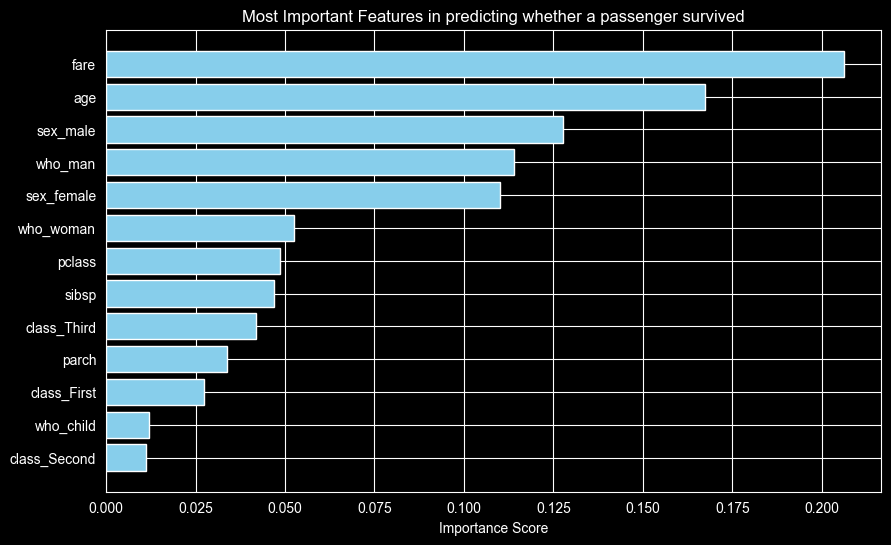


Test set accuracy: 83.24%


In [18]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

# Print test score
test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

### Ejercicio 6. Estos son resultados interesantes para considerar.
¿Qué puedes decir sobre estas importancias de características? ¿Son informativas tal como están?

La precisión en el conjunto de prueba es medianamente satisfactoria. Sin embargo, respecto a las importancias de las características, es crucialmente importante darse cuenta de que lo más probable es que exista mucha dependencia entre estas variables, y se requiere un enfoque de modelado más detallado que incluya análisis de correlación para sacar conclusiones adecuadas. Por ejemplo, sin duda hay información significativa compartida entre las variables age, sex_male y who_man.

## Probar otro modelo
En la práctica, querrías probar diferentes modelos e incluso revisar el análisis de datos para mejorar el rendimiento de tu modelo. Tal vez puedas crear nuevas características o imputar valores faltantes para poder utilizar más datos.

Con la potente clase Pipeline de Scikit-learn, esto es fácil de hacer en unos pocos pasos.
Actualicemos el pipeline y la cuadrícula de parámetros para poder entrenar un modelo de Regresión Logística y comparar el rendimiento de los dos modelos.

In [19]:
# Replace RandomForestClassifier with LogisticRegression
pipeline.set_params(classifier=LogisticRegression(random_state=42))

# update the model's estimator to use the new pipeline
model.estimator = pipeline

# Define a new grid with Logistic Regression parameters
param_grid = {
    # 'classifier__n_estimators': [50, 100],
    # 'classifier__max_depth': [None, 10, 20],
    # 'classifier__min_samples_split': [2, 5],
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid

# Fit the updated pipeline with Logistic Regression
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

Ejercicio 7. Mostrar el reporte de clasificación para el nuevo modelo y comparar los resultados con tu modelo anterior.

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



Ejercicio 8. Mostrar la matriz de confusión para el nuevo modelo y comparar los resultados con tu modelo anterior.

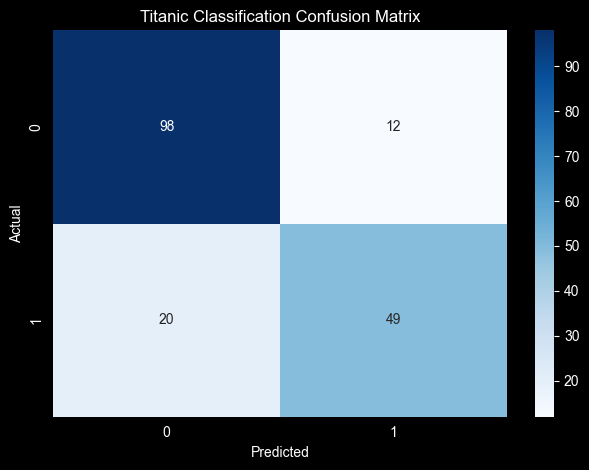

In [21]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')

# Set the title and labels
plt.title('Titanic Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.tight_layout()
plt.show()

### Extraer los coeficientes de características de la regresión logística y graficar su magnitud en un gráfico de barras.

In [22]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

### Ejercicio 9. Graficar las magnitudes de los coeficientes de características en un gráfico de barras
¿Qué diferencia hay entre este gráfico y el gráfico de importancia de características del clasificador Random Forest?

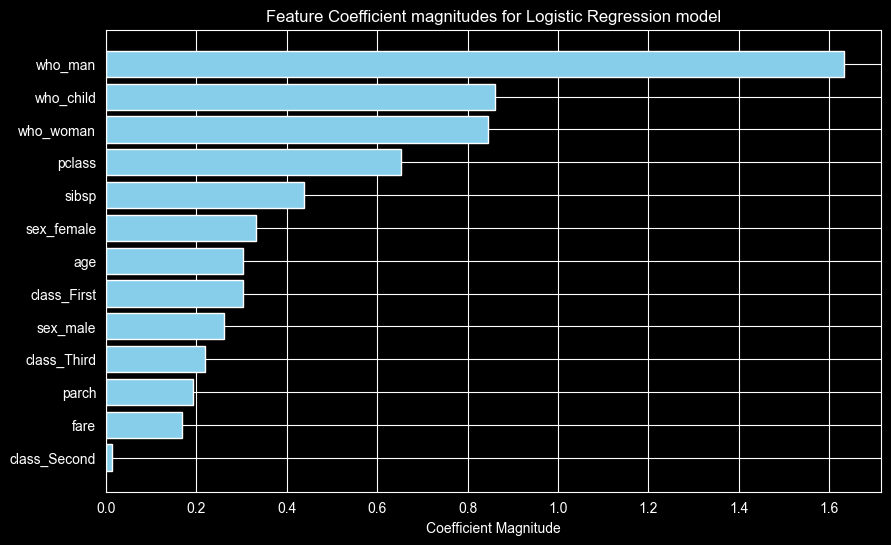


Test set accuracy: 82.12%


In [23]:
# Create a DataFrame for the coefficients
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

Aunque el rendimiento de los dos modelos es prácticamente idéntico, las características que son importantes para cada modelo son muy diferentes. Esto sugiere que debe haber más trabajo por hacer para comprender mejor las importancias reales de las características. Como se mencionó anteriormente, es crucialmente importante darse cuenta de que lo más probable es que exista mucha dependencia entre estas variables, y se requiere un enfoque de modelado más detallado que incluya análisis de correlación para sacar conclusiones adecuadas. Por ejemplo, hay información significativa implícita entre las variables who_man, who_woman y who_child, porque si una persona no es hombre ni mujer, entonces debe ser un niño.